In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction, get_react_prouct, get_molecule_svg, draw_molecule
from utils.dataset_utils import prune_dataset_by_length
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple

RDKit WARNING: [00:22:15] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
import pickle
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
from rdkit.Chem import rdDepictor
IPythonConsole.molSize = (400,400)

In [4]:
def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

In [5]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [6]:
with open('../scripts/graph_models/MT_EGTBF.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [7]:
device = 'cuda:0'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [8]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [9]:
with open('../data/graphs/meta.pkl', 'wb') as f:
    pickle.dump(meta, f)

In [12]:
if data_cfg.same_bond:
    bond2label = {i: 0 if i in meta['type'] else bond2label[i] for i in bond2label}
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

model = RGCNNTrClassifier([len(node2label)] + data_cfg.feature_sizes,
                          num_nodes,
                          train_cfg.batch_size,
                          [model_cfg.n_hidden] + [model_cfg.feature_embed_size] * len(data_cfg.feature_sizes),
                          num_rels,
                          model_cfg.num_conv_layers,
                          model_cfg.num_trans_layers,
                          model_cfg.num_fcn_layers,
                          model_cfg.num_attention_heads,
                          model_cfg.num_model_heads,
                          )

In [13]:
test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [14]:
model = torch.load(paths.save_path)
model = model.to(device)

In [15]:
evaluate(model, test_loader, names=train_cfg.eval_names)
pass

Main product mapping was done with 0.9875487013456858 F1-measure and 0.7457286155202821 full-match accuracy


/home/socrates/miniconda3/envs/chem/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Center of reaction was done with 0.8820385819431898 F1-measure and 0.6614583333333334 full-match accuracy


{0: {'FM': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,

In [16]:
predictions = test(model, test_loader, drop_pad=False)

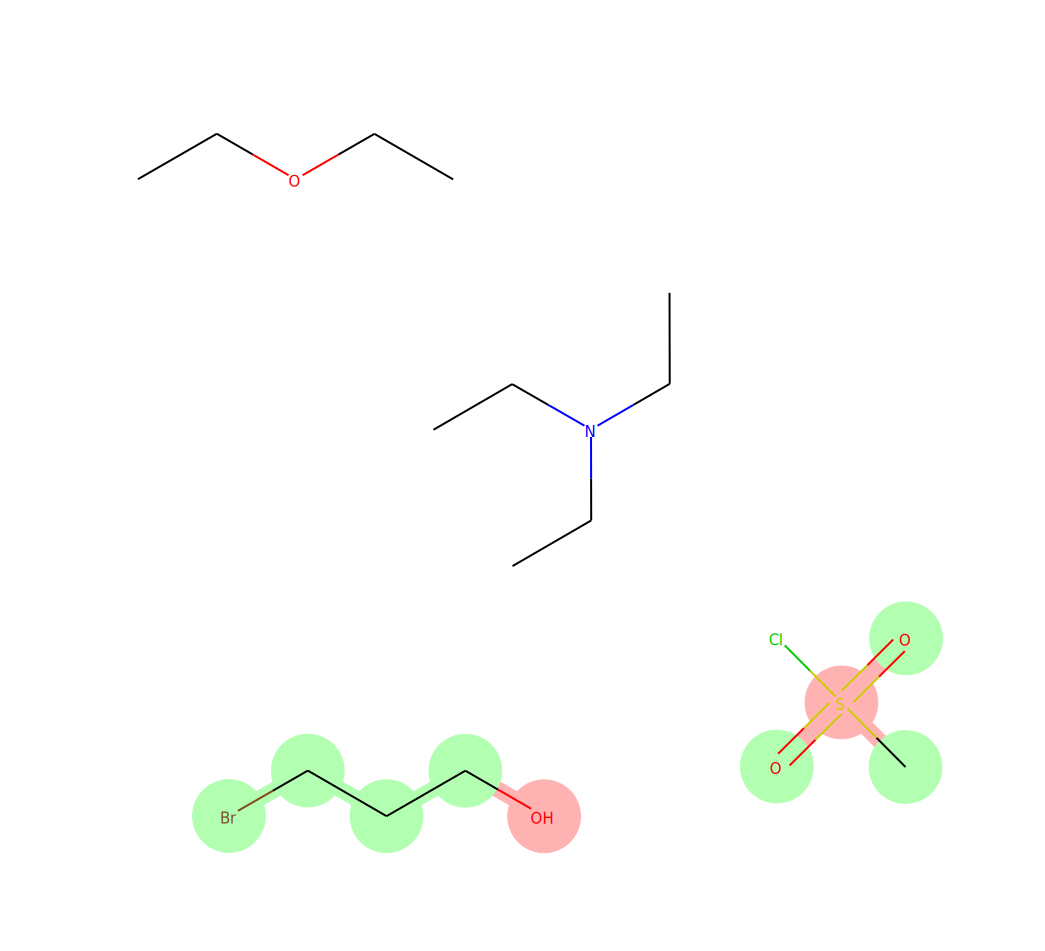

In [21]:
keys = list(test_dataset.keys())
idx = 0
data = test_dataset[keys[idx]]
r_mol, p_mol = get_react_prouct(data['smarts'])
rdDepictor.Compute2DCoords(r_mol)
target_reactants = data['target_main_product'] + data['target_center']
target_reactants[target_reactants == -1] = 0
r = get_molecule_svg(r_mol, target=target_reactants, target_type='GT',
                         gt_colors={1: (0.7, 1, 0.7), 2: (1, 0.7, 0.7)}, dpa=100)
SVG(r)

In [22]:
n_atoms = len(data['target_main_product'])
mp = predictions[0]['predicted'][idx].astype(float)[:n_atoms]
c = predictions[1]['predicted'][idx].astype(float)[:n_atoms]
c[data['target_center'] < 0] = 0
tc = predictions[1]['target'][idx].astype(float)[:n_atoms]

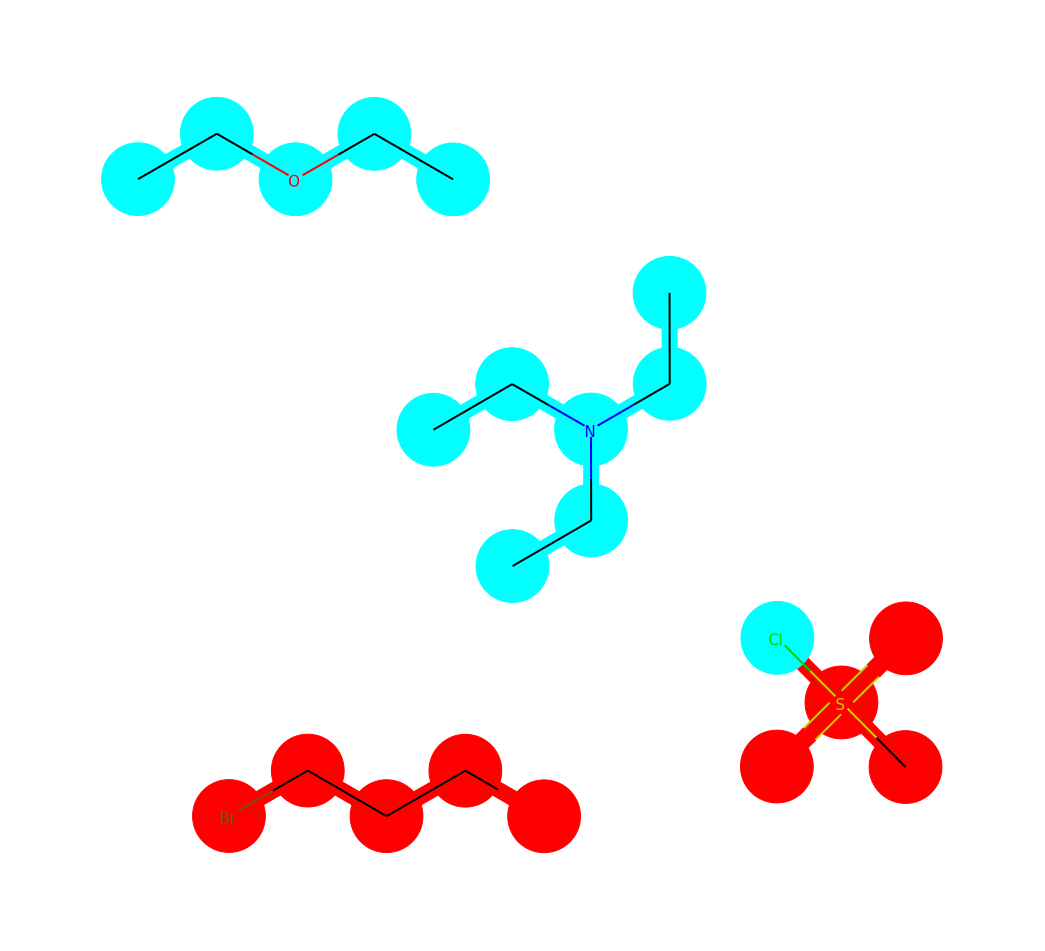

In [23]:
r = get_molecule_svg(r_mol, target=mp, dpa=100)
SVG(r)

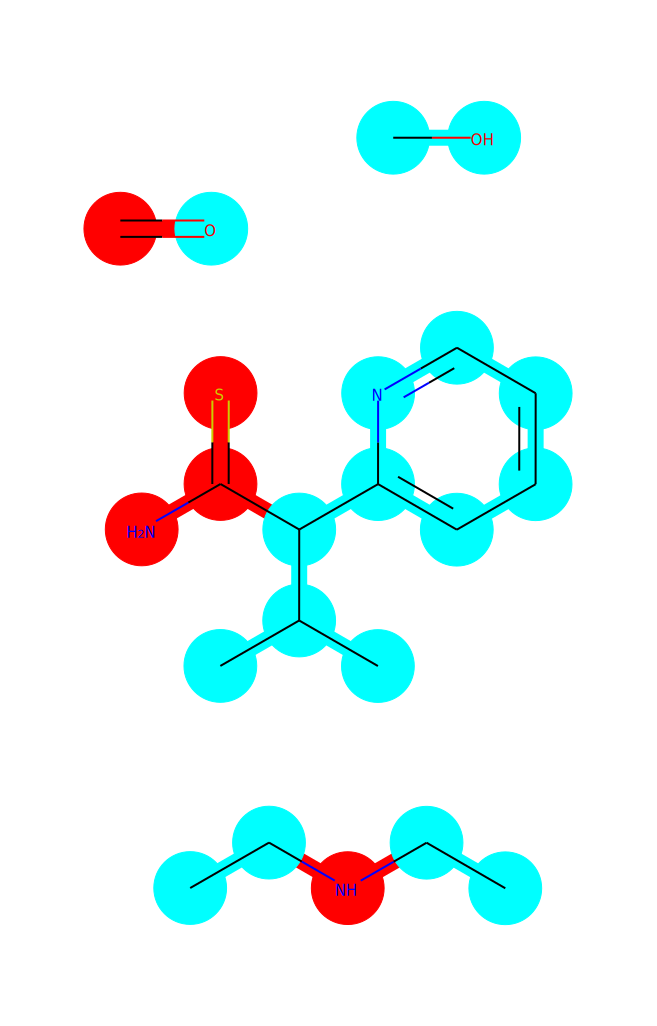

In [20]:
r = get_molecule_svg(r_mol, target=c, dpa=100)
SVG(r)